In [9]:
import os
import gzip
import pandas as pd
import numpy as np

In [10]:
with gzip.open('../datasets/supreme-court-opinions-by-author.jsonl.gz', 'rt') as fh:
    df = pd.read_json(fh, lines=True).set_index(['us_reports_citation', 'authors'])
df.loc['410 US 113']

,case_id,text,type,year
authors,,,,
blackmun,1972-048,\nOPINION BY: BLACKMUN\nOPINION\nMR. JUSTICE B...,opinion,1973
stewart,1972-048,"\nCONCUR BY: STEWART\nMR. JUSTICE STEWART, con...",concur,1973
rehnquist,1972-048,\nDISSENT BY: REHNQUIST\nMR. JUSTICE REHNQUIST...,dissent,1973


In [11]:
print(df.loc['410 US 113'].loc['blackmun', 'text'][:250])


OPINION BY: BLACKMUN
OPINION
MR. JUSTICE BLACKMUN delivered the opinion of the Court.
This Texas federal appeal and its Georgia companion, Doe v. Bolton, post, p. 179, present constitutional challenges to state criminal abortion legislation. The Tex


<AxesSubplot:>

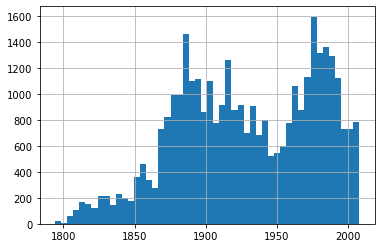

In [12]:
df['year'].hist(bins=50)

In [13]:
df['year'].describe()

count    34677.000000
mean      1928.824552
std         48.821262
min       1794.000000
25%       1890.000000
50%       1927.000000
75%       1974.000000
max       2008.000000
Name: year, dtype: float64

In [14]:
import sklearn.feature_extraction.text as text

vec= text.CountVectorizer(lowercase=True, min_df=100, stop_words='english')
dtm = vec.fit_transform(df['text'])

print(f'Shape of document-term matrix: {dtm.shape}. '
     f'Number of tokens: {dtm.sum()}')

Shape of document-term matrix: (34677, 13231). Number of tokens: 36139890


In [15]:
import sklearn.decomposition as decomposition
model = decomposition.LatentDirichletAllocation(n_components=100, learning_method='online', random_state=1)

document_topic_distributions = model.fit_transform(dtm)
vocabulary = vec.get_feature_names()
assert model.components_.shape == (100, len(vocabulary))
assert document_topic_distributions.shape == (dtm.shape[0], 100)

c:\Users\KSpicer\Anaconda3\envs\victorian_authorship_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
from pickle import dump
dump(model, open('model.pkl', 'wb'))

In [17]:
topic_names = [f'Topic {k}' for k in range(100)]
topic_word_distributions = pd.DataFrame(
    model.components_, columns=vocabulary, index=topic_names)
document_topic_distributions = pd.DataFrame(document_topic_distributions, columns=topic_names, index=df.index)

In [18]:
document_topic_distributions.loc['410 US 113'].loc['blackmun'].head(10)

Topic 0    0.000002
Topic 1    0.001291
Topic 2    0.000592
Topic 3    0.002002
Topic 4    0.003679
Topic 5    0.011683
Topic 6    0.079996
Topic 7    0.000002
Topic 8    0.005844
Topic 9    0.000002
Name: blackmun, dtype: float64

In [19]:
blackmun_opinion = document_topic_distributions.loc['410 US 113'].loc['blackmun']
blackmun_opinion.sort_values(ascending=False).head(10)

Topic 14    0.261380
Topic 63    0.103755
Topic 6     0.079996
Topic 49    0.079675
Topic 17    0.049497
Topic 35    0.038979
Topic 42    0.037718
Topic 93    0.034306
Topic 78    0.033144
Topic 41    0.032153
Name: blackmun, dtype: float64

In [20]:
topic_word_distributions.loc['Topic 14'].sort_values(ascending=False).head(18)

child        7148.398106
children     5668.526880
medical      5167.666624
health       3431.308011
women        3194.024162
treatment    2919.207243
care         2912.593764
hospital     2839.550152
family       2722.583008
age          2686.429177
parents      2646.981270
mental       2515.309043
abortion     2473.571781
social       2115.088729
statute      2025.966412
life         1893.954525
woman        1820.462268
physician    1813.155061
Name: Topic 14, dtype: float64

[Text(0.5, 0, 'Rank of mixing weight'),
 Text(0, 0.5, 'Probability'),
 (0.0, 25.0)]

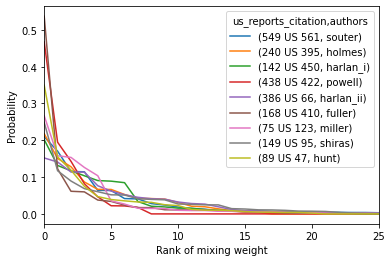

In [21]:
weights_sample = document_topic_distributions.sample(9)
weights_ordered = weights_sample.apply(lambda row: row.sort_values(ascending=False).reset_index(drop=True), axis=1)
ax = weights_ordered.T.plot()
ax.set(xlabel='Rank of mixing weight', ylabel='Probability', xlim=(0,25))

In [22]:
scdb = pd.read_csv('../datasets/scdb_2021_case_based.csv', dtype={'issueArea': float}, encoding='latin1', index_col='caseId')
df_after_1945 = df.loc[df.case_id.isin(scdb.index)]
df_after_1945.columns

Index(['case_id', 'text', 'type', 'year'], dtype='object')

In [23]:
df_after_1945 = df_after_1945.join(scdb['issueArea'], on='case_id')

In [24]:
spaeth_issue_areas = {
    1: 'Criminal Procedure',
    2: 'Civil Rights',
    3: 'First Amendment', 
    4: 'Due Process',
    5: 'Privacy',
    6: 'Attorneys',
    7: 'Unions',
    8: 'Economic Activity',
    9: 'Judicial Power',
    10: 'Federalism',
    11: 'Interstate Relations', 
    12: 'Federal Taxation',
    13: 'Miscellaneous',
    14: 'Private Action'
}

In [25]:
df_after_1945['issueArea'] = pd.Categorical(
    df_after_1945['issueArea'].replace(spaeth_issue_areas), categories=spaeth_issue_areas.values())

In [26]:
import collections
[(issue_area, count)] = collections.Counter(df_after_1945['issueArea']).most_common(1)
print(issue_area, count)
print(count/len(df_after_1945))

Criminal Procedure 4747
0.21037004210059826


In [27]:
document_word_counts = dtm.toarray().sum(axis=1)
document_topic_word_counts = document_topic_distributions.multiply(document_word_counts, axis='index')
df_after_1945 = df_after_1945.join(document_topic_word_counts)

In [28]:
df_after_1945.groupby('issueArea')['Topic 14'].sum()

issueArea
Criminal Procedure       33288.010972
Civil Rights            172757.834085
First Amendment          34239.879011
Due Process              33358.340810
Privacy                  93654.682271
Attorneys                 3454.198377
Unions                    3553.985849
Economic Activity        18875.924499
Judicial Power           23458.627270
Federalism               16451.143912
Interstate Relations        78.270460
Federal Taxation          2052.147267
Miscellaneous              526.598339
Private Action              20.014372
Name: Topic 14, dtype: float64

In [29]:
topic_word_distributions.loc['Topic 14'].sort_values(ascending=False).head()

child       7148.398106
children    5668.526880
medical     5167.666624
health      3431.308011
women       3194.024162
Name: Topic 14, dtype: float64

In [30]:
lauderdale_clark_figure_3_mapping = (
    ('lands, indian, land', 59, 'indian, territory, indians'),
    ('tax, commerce, interstate', 89, 'commerce, interstate, state'),
    ('federal, immunity, law', 2, 'suit, action, states, ... immunity'),
    ('military, aliens, aliens', 22, '..., alien, ..., aliens, ..., deportation, immigration'),
    ('district, habeas, appeal', 43, 'court, federal, district, appeals, review, courts, habeas'),
    ('negligence, martime, admirality', 7, 'vessel, ship, admiralty'),
    ('patent, copyright, cable', 86, 'patent, ..., invention, patents'),
    ('search, fourth, warrant', 37, 'search, warrant, fourth'),
    ('jury, death, penalty', 3, 'sentence, death, sentencing, penalty'),
    ('school, religious, schools', 73, 'religious, funds, ... government, ... establishment'),
    ('trial, counsel, testimony', 13, 'counsel, trial, defendant'),
    ('epa, waste, safety', 95, 'regulations, ..., agency, ..., safety, ..., air, epa'),
    ('speech, ordinance, public', 58, 'speech, amendment, ..., public'),
    ('antitrust, price, securities', 39, 'market, price, competition, act, antitrust'),
    ('child, abortion, children', 14, 'child, children, medical, ..., woman, ... abortion'),
    ('prison, inmates, parole', 67, 'prison, release, custory, parole'),
    ('political, eletion, party', 23, 'speech, amendment, ... political, party'),
    ('title, vii, employment', 55, 'title, discrimination, ..., vii'),
    ('offense, criminal, jeopardy', 78, 'criminal, ..., crime, offense'),
    ('union, labor, board', 24, 'board, union, labor'),
    ('damages, fees, attorneys', 87, 'attorney, fees, ..., costs'),
    ('commission, rates, gas', 97, 'rate, ..., gas, ..., rates'),
    ('congress, act, usc', 41, 'federal, congress, act, law')
)

In [31]:
figure_3_topic_names = [f'Topic {t}' for _, t, _ in lauderdale_clark_figure_3_mapping]
df_plot = df_after_1945.groupby('issueArea')[figure_3_topic_names].sum()
df_plot = df_plot.rename(
    columns={
        f'Topic {t}': f'{t}: {figure_3_words}'
        for figure_3_words, t, _ in lauderdale_clark_figure_3_mapping})

Text(0.5, 1.0, 'Topic Model and Expert Label Alignment')

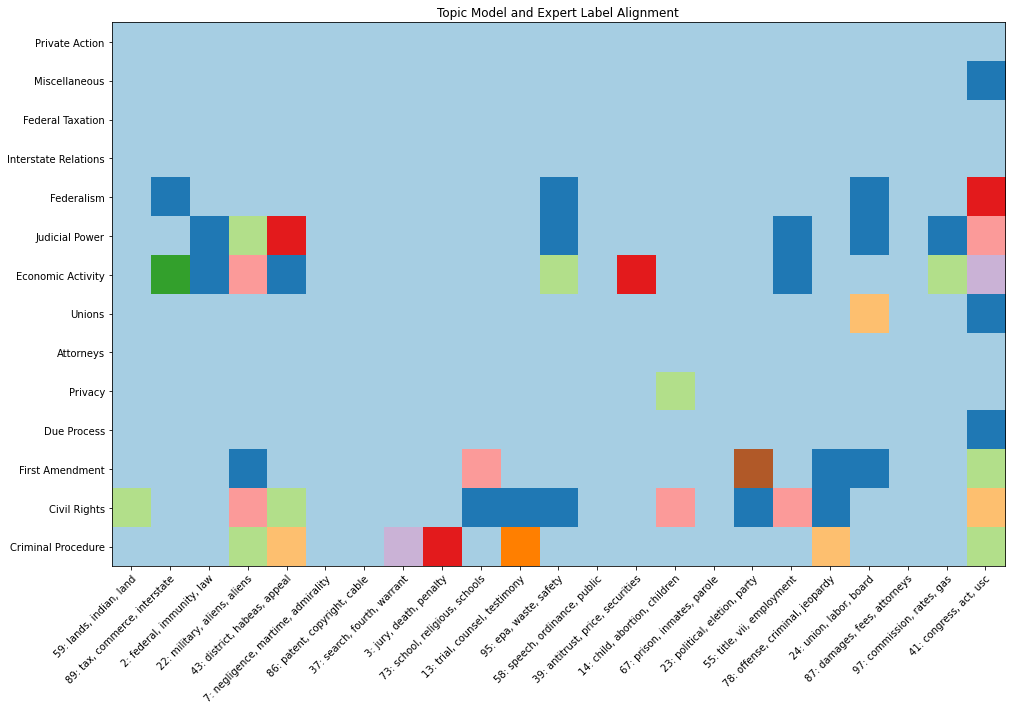

In [80]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
im = ax.imshow(np.flipud(df_plot.values), cmap='Paired')
ax.set_xticks(np.arange(len(df_plot.columns)))
ax.set_yticks(np.arange(len(df_plot.index)))
ax.set_xticklabels(df_plot.columns)
ax.set_yticklabels(reversed(df_plot.index))
plt.setp(
    ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_title('Topic Model and Expert Label Alignment')

In [84]:
viable_top_topics = topic_word_distributions['viable'].sort_values(ascending=False).head(5)

In [85]:
viable_top_topics_top_words = topic_word_distributions.loc[viability_top_topics.index].apply(lambda row: ', '.join(row.sort_values(ascending=False).head().index), axis=1)

In [86]:
viable_top_topics_top_words.name = 'topic_top_words'
#viability_top_topics.to_frame().join(viability_top_topics_top_words)

In [87]:
opinion_of_interest = ('492 US 490', 'rehnquist')
document_topic_distributions.loc[opinion_of_interest, viable_top_topics.index]

C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\488929059.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  document_topic_distributions.loc[opinion_of_interest, viable_top_topics.index]


,,Topic 14,Topic 95,Topic 44,Topic 63,Topic 6
us_reports_citation,authors,,,,,
492 US 490,rehnquist,0.295593,0.018732,0.030273,0.201863,0.031692


In [88]:
print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])

eamble, contains "findings" by the state legislature that "he life of each human being begins at conception," and that "unborn children have protectable interests in life, health, and well-being." Mo. Rev. Stat. §§ 1.205.1(1), (2) (1986). The Act further requires that all Missouri laws be interpreted to provide unborn children with the same rights enjoyed by other persons, subject to the Federal Constitution and this Court's precedents. § 1.205.2. Among its other provisions, the Act requires that, prior to performing an abortion on any woman whom a physician has reason to believe is 20 or more weeks pregnant, the physician ascertain whether the fetus is viable by performing "such medical examinations and tests as are necessary to make a finding of the gestational age, weight, and lung maturity of the unborn child." § 188.029. The Act also prohibits the use of public employees and facilities to perform or assist abortions not necessary to save the mother's life, and it prohibits the use

C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\2838681114.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])


In [89]:
opinion_of_interest = ('530 US 914', "breyer")
print(df.loc[opinion_of_interest, 'text'].values[0][0:1000])
print(
    f'"viable count in 530 US 914:',
    sum('viable' in word.lower()
       for word in df.loc[opinion_of_interest, 'text'].values[0].split()))


OPINION BY: BREYER
OPINION
JUSTICE BREYER delivered the opinion of the Court.
We again consider the right to an abortion. We understand the controversial nature of the problem. Millions of Americans believe that life begins at conception and consequently that an abortion is akin to causing the death of an innocent child; they recoil at the thought of a law that would permit it. Other millions fear that a law that forbids abortion would condemn many American women to lives that lack dignity, depriving them of equal liberty and leading those with least resources to undergo illegal abortions with the attendant risks of death and suffering. Taking account of these virtually irreconcilable points of view, aware that constitutional law must govern a society whose different members sincerely hold directly opposing views, and considering the matter in light of the Constitution's guarantees of fundamental individual liberty, this Court, in the course of a generation, has determined and then re

C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\196871453.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(df.loc[opinion_of_interest, 'text'].values[0][0:1000])
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\196871453.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  for word in df.loc[opinion_of_interest, 'text'].values[0].split()))


In [90]:
document_topic_distributions.loc[opinion_of_interest, viable_top_topics.index.tolist() + ['Topic 63']]

C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\374773060.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  document_topic_distributions.loc[opinion_of_interest, viable_top_topics.index.tolist() + ['Topic 63']]


,,Topic 14,Topic 95,Topic 44,Topic 63,Topic 6,Topic 63
us_reports_citation,authors,,,,,,
530 US 914,breyer,0.224984,0.005495,0.047712,0.084685,0.076968,0.084685


In [92]:
topic_oi = 'Topic 63'
topic_oi_words = ', '.join(topic_word_distributions.loc[topic_oi].sort_values(ascending=False).head(8).index)
print(f'Topic 63 top words:\n   {topic_oi_words}')

Topic 63 top words:
   court, id, 2d, supra, cases, rule, case, decision


In [93]:
import itertools

opinion_text = df.loc[opinion_of_interest, 'text'][0]
window_width, num_words = 3, len(opinion_text.split())
words = iter(opinion_text.split())
windows = [' '.join(itertools.islice(words, 0, window_width))
           for _ in range(num_words // window_width)]
print([window for window in windows if 'viable' in window])

['a nonviable fetus."', 'circumstances involving nonviable', 'a nonviable fetus."']


C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\2488274920.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  opinion_text = df.loc[opinion_of_interest, 'text'][0]


In [42]:
topic_fourteen = 'Topic 14'
topic_word_distributions.loc[topic_fourteen].sort_values(ascending=False).head(10)

child        7148.398106
children     5668.526880
medical      5167.666624
health       3431.308011
women        3194.024162
treatment    2919.207243
care         2912.593764
hospital     2839.550152
family       2722.583008
age          2686.429177
Name: Topic 14, dtype: float64

In [94]:
topic_top_words = topic_word_distributions.loc[topic_fourteen].sort_values(ascending=False).head(10).index
topic_top_words_joined = ', '.join(topic_top_words)
print(topic_top_words_joined)

child, children, medical, health, women, treatment, care, hospital, family, age


In [95]:
opinion_word_counts = np.array(dtm.sum(axis=1)).ravel()
word_counts_by_year = pd.Series(opinion_word_counts).groupby(df.year.values).sum()
topic_word_counts = document_topic_distributions.multiply(opinion_word_counts, axis='index')
topic_word_counts_by_year = topic_word_counts.groupby(df.year.values).sum()
topic_proportion_by_year = topic_word_counts_by_year.divide(word_counts_by_year, axis='index')
topic_proportion_by_year.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 90,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99
1794,0.000038,0.019573,0.000038,0.000038,0.021096,0.000038,0.000038,0.013707,0.000038,0.000038,...,0.000038,0.000038,0.000038,0.210499,0.002054,0.000038,0.000038,0.000038,0.000038,0.000038
1795,0.000026,0.014169,0.000026,0.000026,0.025628,0.000026,0.000026,0.106625,0.000026,0.000026,...,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026
1796,0.000028,0.036382,0.000028,0.000028,0.004396,0.032959,0.000028,0.021983,0.009850,0.000028,...,0.000028,0.015842,0.000028,0.130444,0.002253,0.000028,0.000028,0.004262,0.000028,0.000028
1797,0.000026,0.015645,0.000026,0.000026,0.010891,0.098829,0.000026,0.081282,0.000026,0.000026,...,0.000026,0.007088,0.011393,0.083118,0.000026,0.000026,0.000026,0.002262,0.000026,0.000026
1798,0.000352,0.009832,0.003496,0.001023,0.002399,0.121964,0.000010,0.000010,0.000010,0.000981,...,0.051774,0.013590,0.002891,0.075408,0.000010,0.000010,0.000010,0.002979,0.000010,0.000010


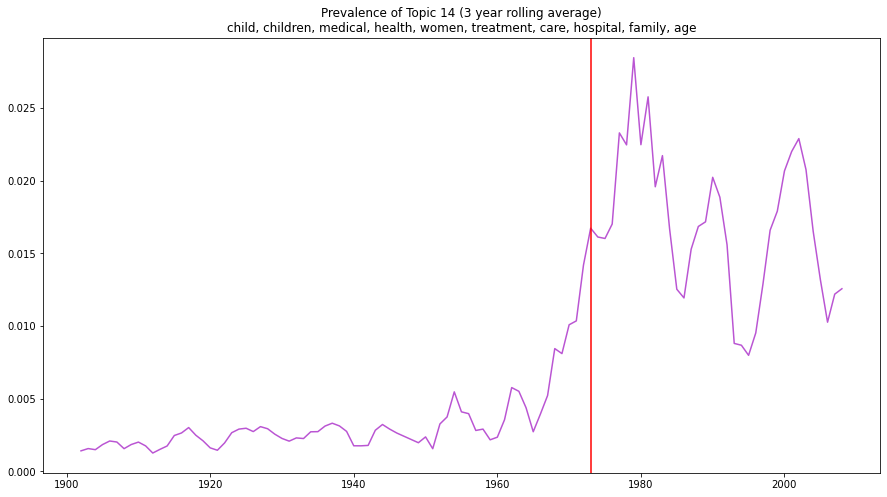

In [102]:
plt.figure(figsize=(15, 8))
window = 3 
topic_proportion_rolling = topic_proportion_by_year.loc[1900:, topic_fourteen].rolling(window=window).mean()
topic_proportion_rolling.plot(color='mediumorchid')
plt.title(f'Prevalence of {topic_fourteen} ({window} year rolling average)'
          f'\n{topic_top_words_joined}')
plt.axvline(x=1973, color='red', label="Roe v. Wade Decision")

Connecticut, in 1905, and  when five years old moved with his parents to Los Angeles, California, where he resided until 1926, when he removed to Berkeley, California.  His parents live in California.  In 1929 he completed his studies at Brown University and immediately thereafter accepted employment in a trust company in Detroit, Michigan, of which one of his former professors at Brown was vice president.  While in Detroit, respondent lived first in a rooming house and later in an apartment. He owns no property there.  In the District of Columbia he lives in an apartment, which he has furnished himself. His present employment pays him $ 6,500 a year, while that which he left in Detroit paid but $ 6,000.  He testified before the Board of Tax Appeals that he does not think he would improve his condition by returning to Detroit, but that "It is the place to which I will return if I ever become disemployed by the Government, which I hope will not happen . . ." Although he has no present c

C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3989174566.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  document_topic_distributions.loc[opinion_of_interest, abortion_top_topics.index]
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3989174566.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3989174566.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for word in df.loc[opinion_of_interest, 'text'].values[0].split()))
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3989174566.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  document_topic_distributions.loc[opinion_of_interest, abortion_top_topics.index.tolist() + ['Topic 63']]
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3989174566.py:21: PerformanceWarning: indexing past lexs

Text(0.5, 1.0, 'Prevalence of Topic 14 (3 year rolling average)\nchild, children, medical, health, women, treatment, care, hospital, family, age')

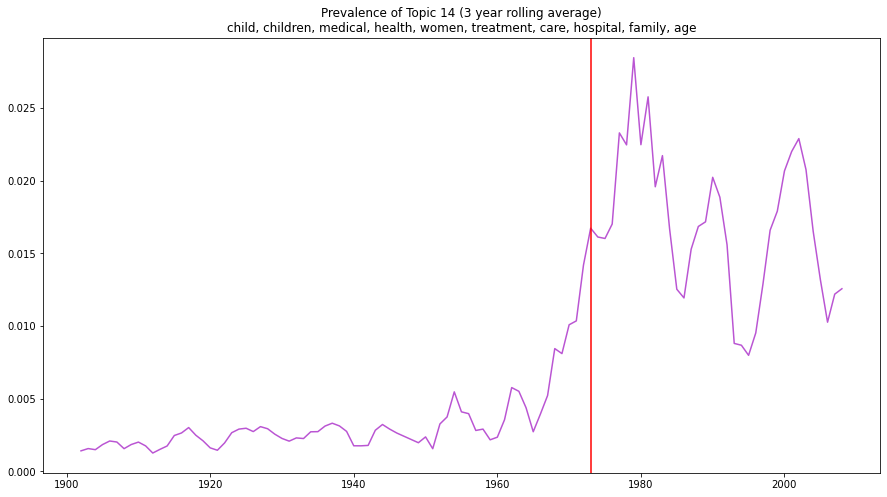

In [103]:
plt.figure(figsize=(15, 8))
abortion_top_topics = topic_word_distributions['abortion'].sort_values(ascending=False).head(5)
viability_top_topics_top_words = topic_word_distributions.loc[abortion_top_topics.index].apply(lambda row: ', '.join(row.sort_values(ascending=False).head().index), axis=1)
viability_top_topics_top_words.name = 'topic_top_words'
#viability_top_topics.to_frame().join(viability_top_topics_top_words)
opinion_of_interest = ('314 US 441', 'jackson_r')
document_topic_distributions.loc[opinion_of_interest, abortion_top_topics.index]
print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])
opinion_of_interest = ('529 US 362', "o'connor")
print(
    f'"abortion" count in 529 US 362:',
    sum('abortion' in word.lower()
       for word in df.loc[opinion_of_interest, 'text'].values[0].split()))
document_topic_distributions.loc[opinion_of_interest, abortion_top_topics.index.tolist() + ['Topic 63']]
topic_oi = 'Topic 63'
topic_oi_words = ', '.join(topic_word_distributions.loc[topic_oi].sort_values(ascending=False).head(8).index)
print(f'Topic 63 top words:\n   {topic_oi_words}')

import itertools

opinion_text = df.loc[opinion_of_interest, 'text'][0]
window_width, num_words = 3, len(opinion_text.split())
words = iter(opinion_text.split())
windows = [' '.join(itertools.islice(words, 0, window_width))
           for _ in range(num_words // window_width)]
print([window for window in windows if 'minor' in window])
topic_fourteen = 'Topic 14'
topic_word_distributions.loc[topic_fourteen].sort_values(ascending=False).head(10)
topic_top_words = topic_word_distributions.loc[topic_fourteen].sort_values(ascending=False).head(10).index
topic_top_words_joined = ', '.join(topic_top_words)
print(topic_top_words_joined)
opinion_word_counts = np.array(dtm.sum(axis=1)).ravel()
word_counts_by_year = pd.Series(opinion_word_counts).groupby(df.year.values).sum()
topic_word_counts = document_topic_distributions.multiply(opinion_word_counts, axis='index')
topic_word_counts_by_year = topic_word_counts.groupby(df.year.values).sum()
topic_proportion_by_year = topic_word_counts_by_year.divide(word_counts_by_year, axis='index')
topic_proportion_by_year.head()
window = 3 
topic_proportion_rolling = topic_proportion_by_year.loc[1900:, topic_fourteen].rolling(window=window).mean()
topic_proportion_rolling.plot(color='mediumorchid')
plt.axvline(x=1973, color='red', label="Roe v. Wade Decision")
plt.title(f'Prevalence of {topic_fourteen} ({window} year rolling average)'
          f'\n{topic_top_words_joined}')

Connecticut, in 1905, and  when five years old moved with his parents to Los Angeles, California, where he resided until 1926, when he removed to Berkeley, California.  His parents live in California.  In 1929 he completed his studies at Brown University and immediately thereafter accepted employment in a trust company in Detroit, Michigan, of which one of his former professors at Brown was vice president.  While in Detroit, respondent lived first in a rooming house and later in an apartment. He owns no property there.  In the District of Columbia he lives in an apartment, which he has furnished himself. His present employment pays him $ 6,500 a year, while that which he left in Detroit paid but $ 6,000.  He testified before the Board of Tax Appeals that he does not think he would improve his condition by returning to Detroit, but that "It is the place to which I will return if I ever become disemployed by the Government, which I hope will not happen . . ." Although he has no present c

C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3772412823.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  document_topic_distributions.loc[opinion_of_interest, abortion_top_topics.index]
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3772412823.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3772412823.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  for word in df.loc[opinion_of_interest, 'text'].values[0].split()))
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3772412823.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  document_topic_distributions.loc[opinion_of_interest, abortion_top_topics.index.tolist() + ['Topic 63']]
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_13228\3772412823.py:21: PerformanceWarning: indexing past lexs

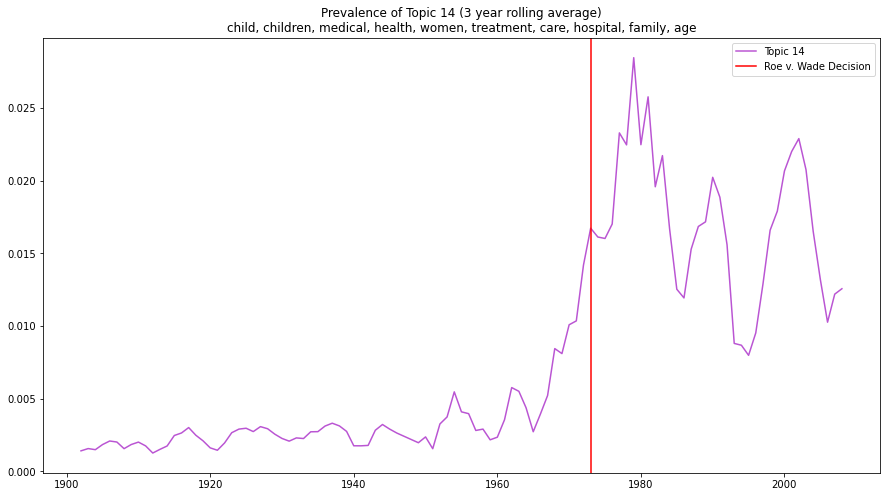

In [104]:
plt.figure(figsize=(15, 8))
abortion_top_topics = topic_word_distributions['abortion'].sort_values(ascending=False).head(5)
viability_top_topics_top_words = topic_word_distributions.loc[abortion_top_topics.index].apply(lambda row: ', '.join(row.sort_values(ascending=False).head().index), axis=1)
viability_top_topics_top_words.name = 'topic_top_words'
#viability_top_topics.to_frame().join(viability_top_topics_top_words)
opinion_of_interest = ('314 US 441', 'jackson_r')
document_topic_distributions.loc[opinion_of_interest, abortion_top_topics.index]
print(df.loc[opinion_of_interest, 'text'].values[0][1000:2000])
opinion_of_interest = ('410 US 113', "blackmun")
print(
    f'"abortion" count in 410 US 113:',
    sum('abortion' in word.lower()
       for word in df.loc[opinion_of_interest, 'text'].values[0].split()))
document_topic_distributions.loc[opinion_of_interest, abortion_top_topics.index.tolist() + ['Topic 63']]
topic_oi = 'Topic 63'
topic_oi_words = ', '.join(topic_word_distributions.loc[topic_oi].sort_values(ascending=False).head(8).index)
print(f'Topic 63 top words:\n   {topic_oi_words}')

import itertools

opinion_text = df.loc[opinion_of_interest, 'text'][0]
window_width, num_words = 3, len(opinion_text.split())
words = iter(opinion_text.split())
windows = [' '.join(itertools.islice(words, 0, window_width))
           for _ in range(num_words // window_width)]
print([window for window in windows if 'minor' in window])
topic_fourteen = 'Topic 14'
topic_word_distributions.loc[topic_fourteen].sort_values(ascending=False).head(10)
topic_top_words = topic_word_distributions.loc[topic_fourteen].sort_values(ascending=False).head(10).index
topic_top_words_joined = ', '.join(topic_top_words)
print(topic_top_words_joined)
opinion_word_counts = np.array(dtm.sum(axis=1)).ravel()
word_counts_by_year = pd.Series(opinion_word_counts).groupby(df.year.values).sum()
topic_word_counts = document_topic_distributions.multiply(opinion_word_counts, axis='index')
topic_word_counts_by_year = topic_word_counts.groupby(df.year.values).sum()
topic_proportion_by_year = topic_word_counts_by_year.divide(word_counts_by_year, axis='index')
topic_proportion_by_year.head()
window = 3 
topic_proportion_rolling = topic_proportion_by_year.loc[1900:, topic_fourteen].rolling(window=window).mean()
topic_proportion_rolling.plot(color='mediumorchid')
plt.axvline(x=1973, color='red', label="Roe v. Wade Decision")
plt.title(f'Prevalence of {topic_fourteen} ({window} year rolling average)'
          f'\n{topic_top_words_joined}')
plt.legend()